# Fitting With Priors

In this notebook we use `boax` to extend the getting started workflow by introducing priors to the Gaussian Process model parameters.

In [1]:
from jax import config

config.update("jax_enable_x64", True)

from jax import numpy as jnp
from jax import jit, lax, nn, random, value_and_grad, vmap

import optax
import matplotlib.pyplot as plt

plt.style.use('bmh')

from boax.core import distributions, samplers
from boax.prediction import models, objectives
from boax.optimization import acquisitions, optimizers

As part of the environment we initialize two PRNG keys with a starting seed of 0.

In [2]:
sampler_key, optimizer_key = random.split(random.key(0))

## Defining the latent objective function

As for the last guide we choose a modified 1-dimensional Forrester function, that we aim to maximize in the interval of `[-5, 5]`.

In [3]:
def objective(x):
    return -((x[..., 0] + 1) ** 2) * jnp.sin(2 * x[..., 0] + 2) / 5 + 1

When defining the objective function we expect an input of shape `(n, d)`, where `n` indicates the number of examples in the training set and `d` indicates the number of dimensions for each data point.

In [4]:
bounds = jnp.array([[-5.0, 5.0]])

The bounds are of shape `(d, 2)`, where `d` indicates the number of dimensions, each described by a lower and upper bound.

## Generating training data

In this example we assume to have already evaluated the objective function at the points `x=1` and `x=2`.

In [5]:
x_train = jnp.array([[1.0], [2.0]])
y_train = objective(x_train)

In the following we plot the observations from the evaluation in the context of the latent objective function.

In [6]:
xs = jnp.linspace(bounds[:, 0], bounds[:, 1], 501)
ys = objective(xs)

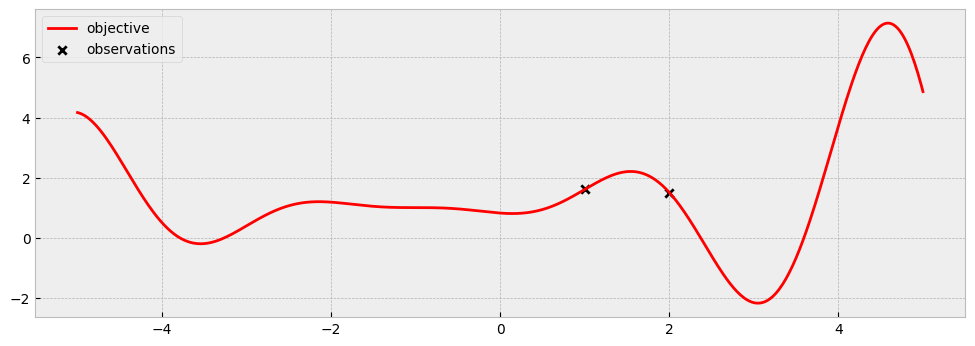

In [7]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(xs, ys, c='r', label='objective')
ax.scatter(x_train, y_train, marker='x', c='k', label='observations')
ax.legend()

plt.show()

## Fitting a Gaussian Process model to the data

With the observations in place, we can now focus on fitting a Gaussian Process model to the training data. We choose a simple Gaussian Process model setup with a zero mean function, a scaled matérn 2.5 kernel, and a gaussian likelihood.

In [8]:
def model_fn(params, x_train, y_train):
    return models.gaussian_process(
        models.means.zero(),
        models.kernels.scaled(
            models.kernels.matern_five_halves(nn.softplus(params['length_scale'])),
            nn.softplus(params['amplitude'])
        ),
        models.likelihoods.gaussian(1e-4),
        x_train,
        y_train,
    )

Next, we define the loss function used to fit the model to the training data. For this setup we select the negative log likelihood penalized by our priors.

In [9]:
def loss_fn(params, x_train, y_train):
    y_hat = model_fn(params, None, None)(x_train)
    
    objective = objectives.penalized(
        objectives.negative_log_likelihood(
            distributions.multivariate_normal.logpdf
        ),
        -jnp.sum(
            distributions.gamma.logpdf(
                distributions.gamma.gamma(2.0, 0.15),
                nn.softplus(params['amplitude']),
            )
        ),
        -jnp.sum(
            distributions.gamma.logpdf(
                distributions.gamma.gamma(3.0, 6.0),
                nn.softplus(params['length_scale']),
            )
        )
    )

    return objective(y_hat, y_train)

Subsequentely, we initialise the model parameters and the optimizer from the `optax` library.

In [10]:
params = {
    'length_scale': jnp.zeros(()),
    'amplitude': jnp.zeros(()),
}

In [11]:
adam = optax.adam(0.01)

Finally, we have everything we need to define the model fitting function.

In [12]:
def fit(x_train, y_train):
    def step(state, i):
        loss, grads = value_and_grad(loss_fn)(state[0], x_train, y_train)
        updates, opt_state = adam.update(grads, state[1])
        params = optax.apply_updates(state[0], updates)

        return (params, opt_state), loss

    (next_params, _), _ = lax.scan(
        jit(step),
        (params, adam.init(params)),
        jnp.arange(500),
    )

    return next_params

## Constructing an acquisition function and selecting the next data points to query

The next step in the bayesian optimization process is the construction of an acqusition function that guides our decision of selecting a new point to query the latent objective function. For this example we select the Upper Confidence Bound (UCB) acquisition function, which we optimize using the BFGS optimizer.

In [13]:
def acquisition_fn(model, beta):
    ucb = acquisitions.upper_confidence_bound(beta)

    def fn(x):
        return ucb(vmap(model)(x))
    
    return fn

The optimizer requires a set of initial candidates denoted as `x0`. We generate this initial candidate set using the halton uniform sampler.

In [14]:
x0 = jnp.reshape(
    samplers.halton_uniform(
        distributions.uniform.uniform(bounds[:, 0], bounds[:, 1])
    )(
        sampler_key,
        100,
    ),
    (100, 1, -1),
)

In [15]:
def select(acqf, key):
    bfgs = optimizers.bfgs(jit(acqf), bounds, x0, 10)
    candidates = bfgs.init(key)
    next_candidates, values = bfgs.update(candidates)
    
    return next_candidates[jnp.argmax(values)]

## Running the experiment

Finally we have everything setup to run the bayesian optimization loop. In order to better retrace the process we define a final function that visualizes our current believe of the latent objective function and the acquisition function at each step.

In [16]:
def visualize(model, acqf, next_x):
    loc, scale = model(xs)
    scores = acqf(xs[..., jnp.newaxis])
    
    fig, axs = plt.subplots(
        2,
        1,
        figsize=(12, 6),
        sharex=True,
        gridspec_kw={'height_ratios': [2, 1]}
    )

    axs[0].plot(xs, ys, c='r', label='objective')
    axs[0].scatter(x_train, y_train, marker='x', c='k', label='observations')
    axs[0].plot(xs, loc, label='mean')
    axs[0].fill_between(
        xs.flatten(),
        loc - 2 * scale,
        loc + 2 * scale,
        alpha=0.3,
        label='95% CI'
    )

    axs[0].axvline(next_x, linestyle='dotted', c='k')

    axs[0].legend(loc='upper left')
    axs[0].set_ylabel('predictive')

    axs[1].plot(xs, scores, c='g')
    axs[1].fill_between(
        xs.flatten(),
        scores,
        0,
        color='g',
        alpha=0.5,
    )

    axs[1].axvline(next_x, linestyle='dotted', c='k')

    axs[1].set_ylabel('acquisition score')

    plt.show()

The bayesian optimization loop is implemented analogue to the standard loop from the Getting Started guide. However, we introduce two additions for a smoother optimization. Firstly, we standarize the training data, and secondly, we define a dynamic beta parameter for the UCB acquisition function.

In [17]:
beta = 1
factor = 10 ** (1 / 10)

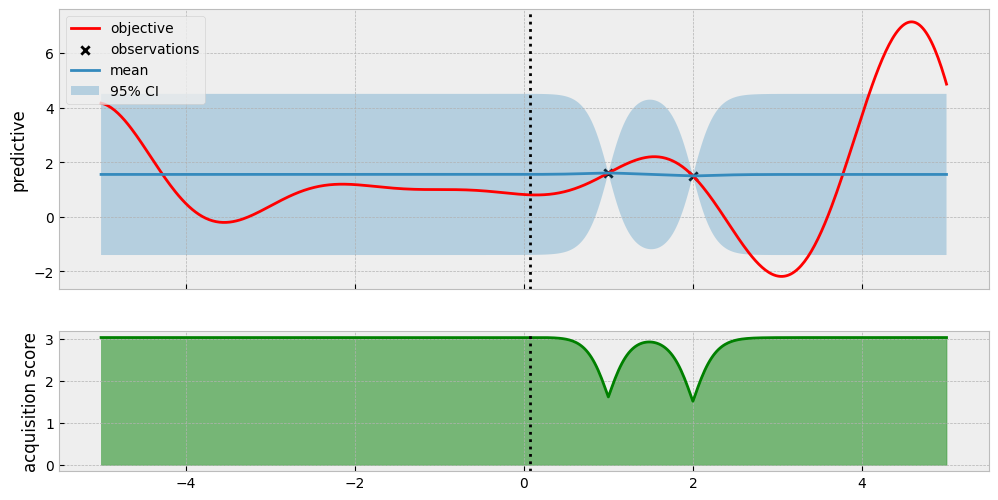

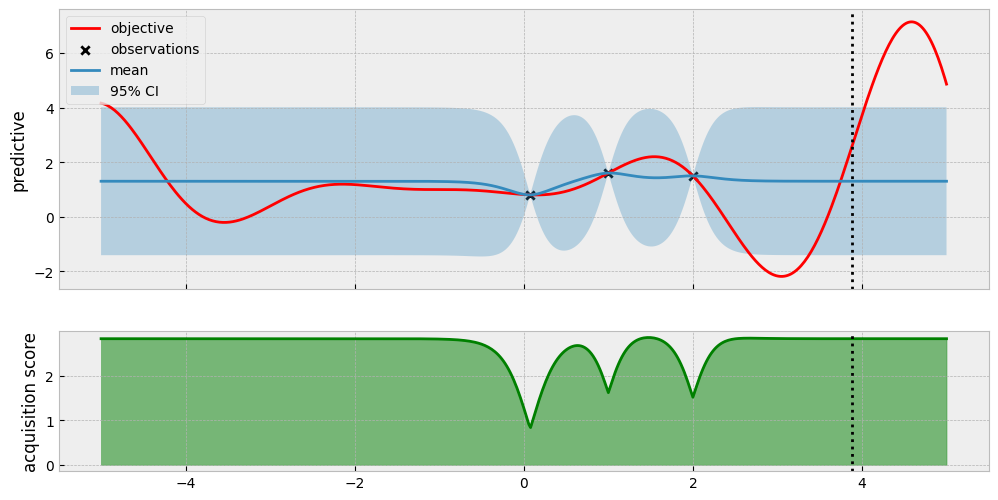

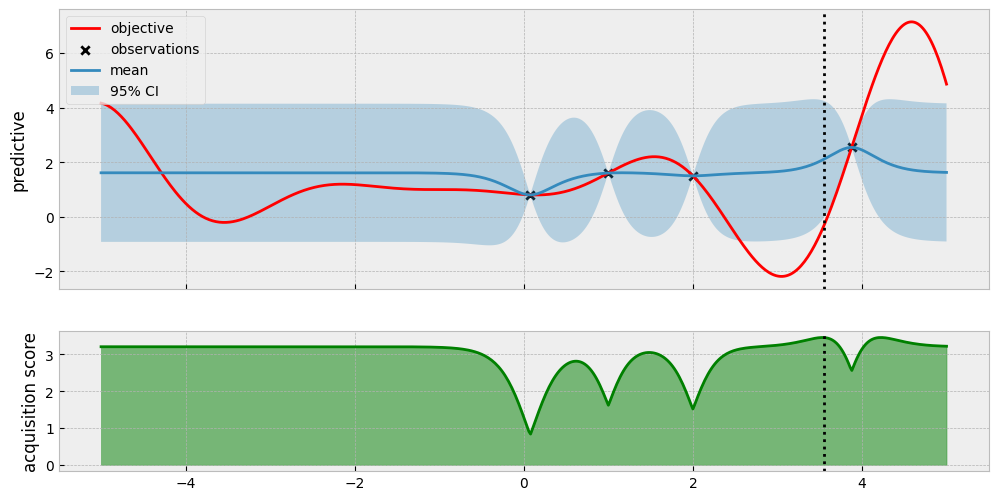

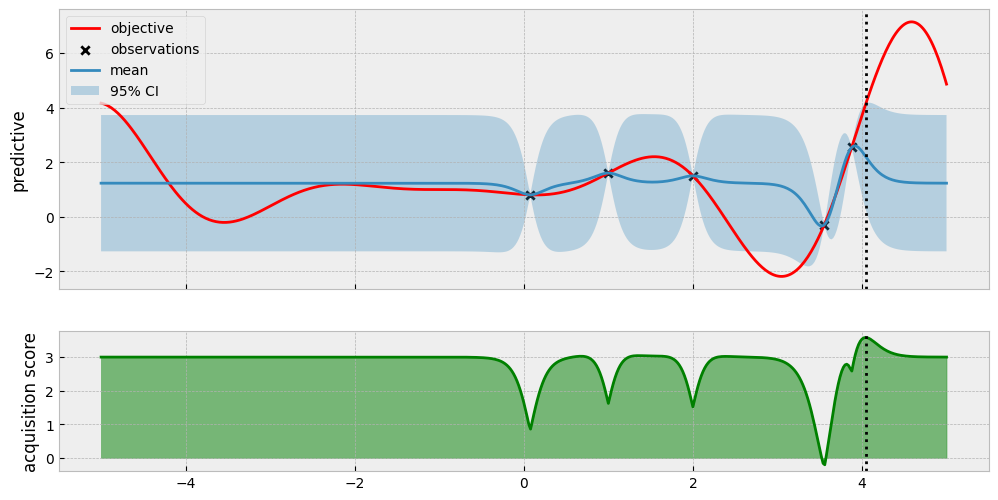

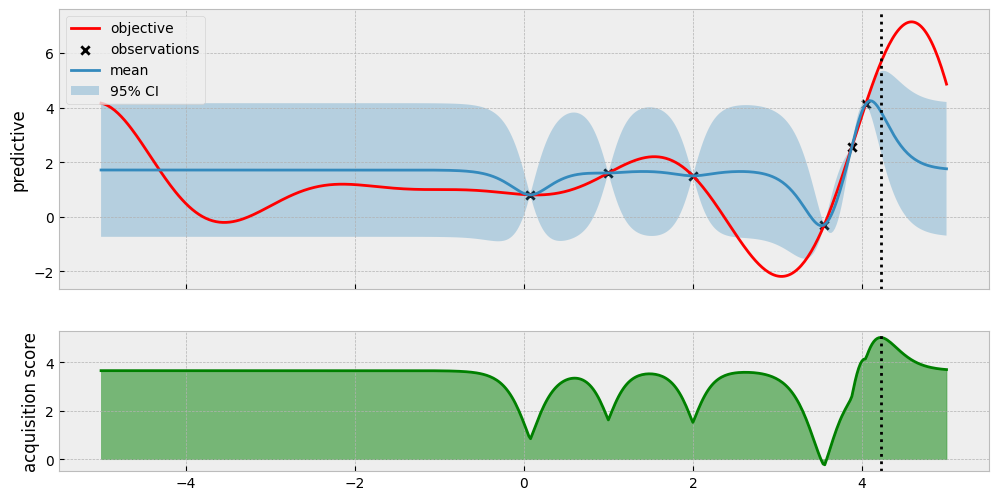

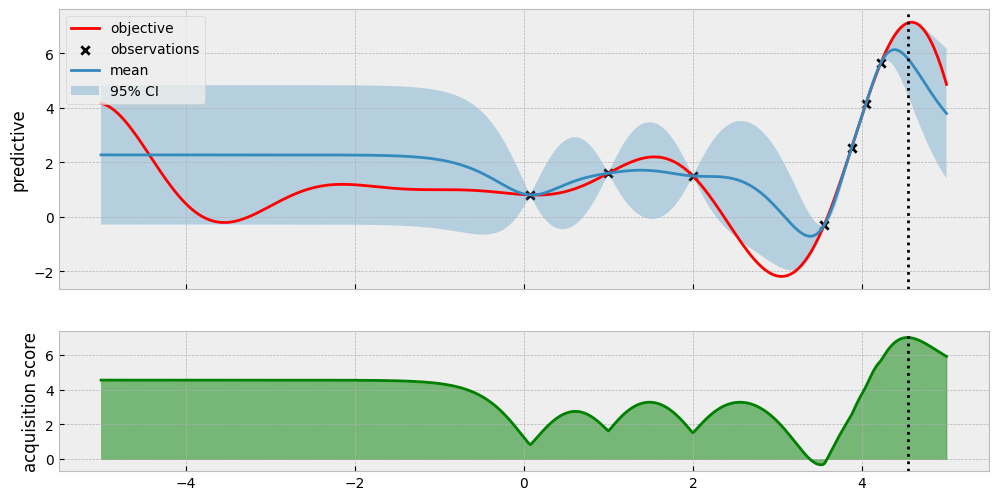

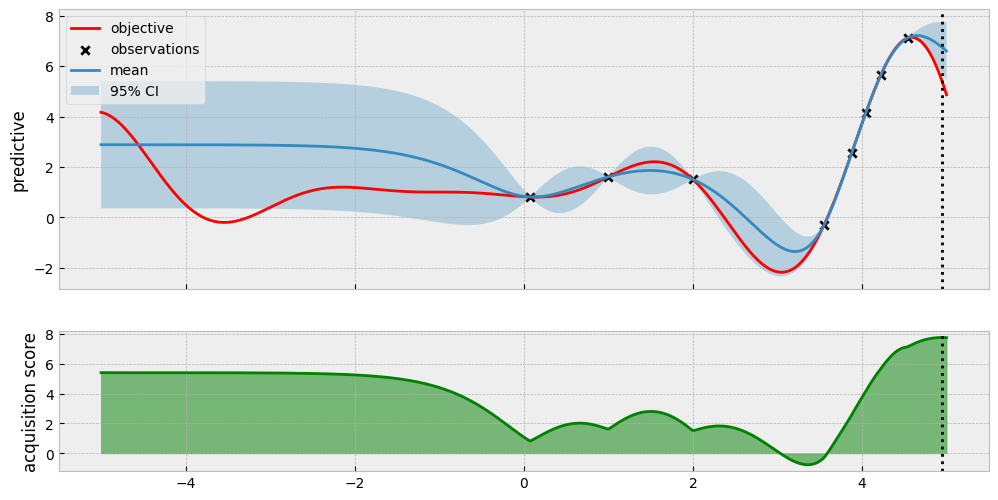

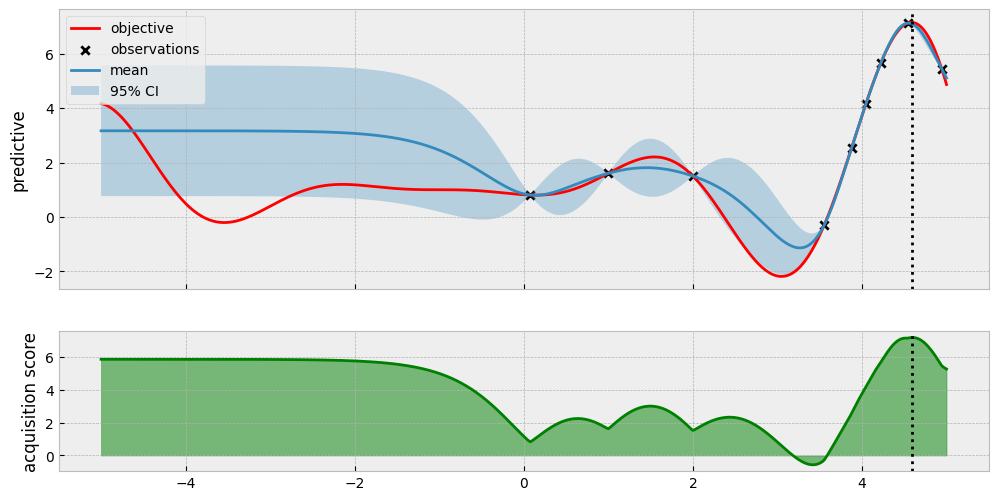

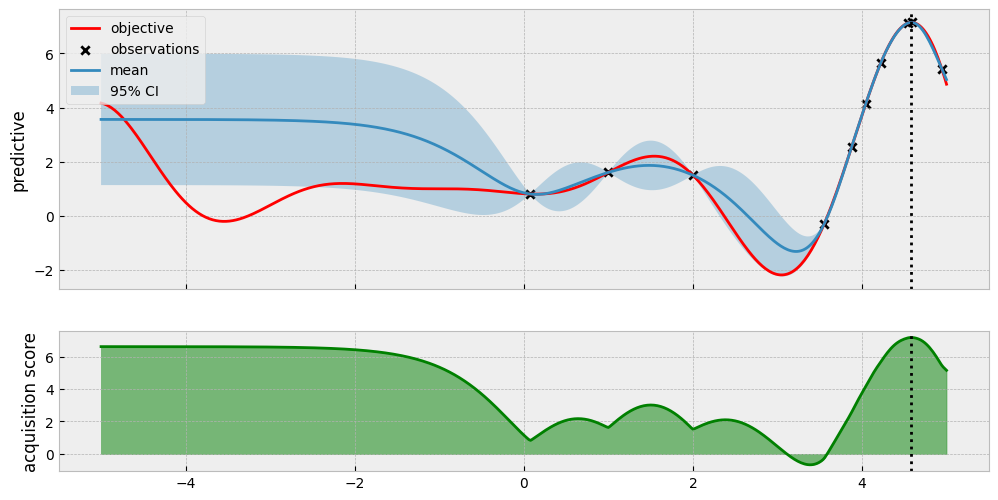

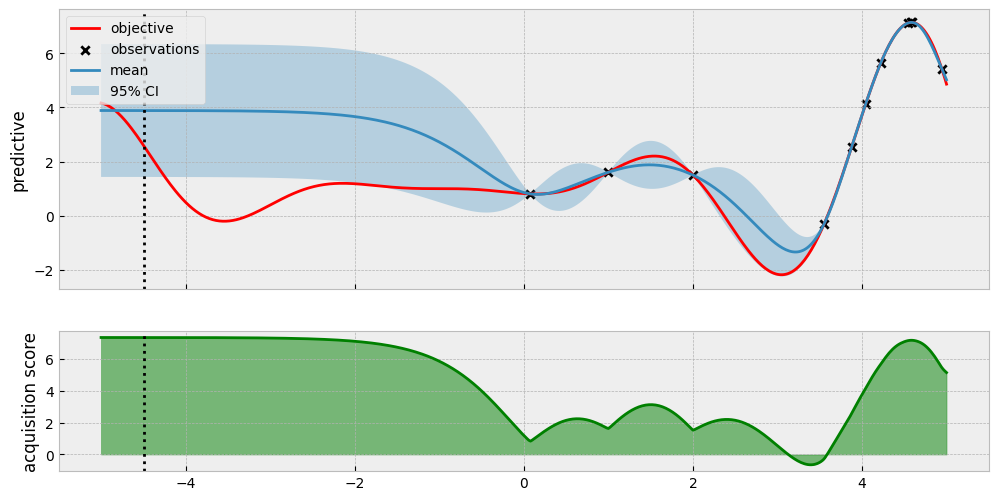

In [18]:
for i in range(10):
    # Fitting
    y_mean, y_var = jnp.mean(y_train), jnp.var(y_train)
    y_norm = nn.standardize(y_train, mean=y_mean, variance=y_var)
    next_params = fit(x_train, y_norm)

    model = models.scaled(
        models.outcome_transformed(
            model_fn(next_params, x_train, y_norm),
            distributions.mvn_to_norm,
        ),
        distributions.normal.scale,
        loc=y_mean,
        scale=jnp.sqrt(y_var),
    )

    # Optimizing
    acqf = acquisition_fn(model, beta)
    
    next_x = select(
        acqf,
        random.fold_in(optimizer_key, i),
    )

    # Evaluating
    next_y = objective(next_x)

    # Visualizing
    visualize(
        model,
        acqf,
        next_x,
    )

    # Updating the training data
    x_train = jnp.vstack([x_train, next_x])
    y_train = jnp.hstack([y_train, next_y])

    # Updating beta
    beta *= factor